# Creating a Databunch for Basecalling

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.basics import *

import jkbc.utils.preprocessing as prep
import jkbc.utils.postprocessing as pop
import jkbc.utils.files as f

## Constants

In [4]:
BLANK_ID = 4
C = 5
D_in = 300
D_h = 201
D_out_max = 60
n_hidden = 400
BS = 64 #64 # batch size
LR = 0.05

#DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda:0")

## Load Data

In [5]:
base_dir = "data/feather-files/"
path_data = Path(base_dir)
data_set_name = 'Range0-100-FixLabelLen60'
feather_folder = path_data/data_set_name

In [6]:
# Read data from feather
data = f.read_data_from_feather_file(feather_folder)
x, y_train = data

# Convert to databunch
train, valid = prep.convert_to_datasets(data, split=.8, window_size=D_in)
databunch = DataBunch.create(train, valid, bs=BS, device=DEVICE)

In [7]:
# Create lengths to be used in ctc_loss
y_pred_lengths, y_lengths = prep.get_y_lengths(D_in, D_out_max, BS)

## Model

In [8]:
ctc_loss = nn.CTCLoss()
def ctc_loss_custom(y_pred_b: torch.Tensor, y_b: torch.Tensor) -> float:
    if y_pred_lengths.shape[0] != y_pred_b.shape[0]:
        new_len = y_pred_b.shape[0]
        y_pred_lengths_ = y_pred_lengths[:new_len]
        y_lengths_ = y_lengths[:new_len]
    else:
        y_pred_lengths_ = y_pred_lengths
        y_lengths_ = y_lengths
    
    y_pred_b_ = y_pred_b.reshape((y_pred_b.shape[1], y_pred_b.shape[0], C))

    return ctc_loss(y_pred_b_, y_b, y_pred_lengths_, y_lengths_)    

In [9]:
loss_func = ctc_loss_custom

In [10]:
def conv(ni, nf): return nn.Conv1d(ni, nf, kernel_size=3, stride=2, padding=1)

model = nn.Sequential(
    nn.Linear(300, 500)
    ,nn.ReLU()
    ,nn.Linear(500, 300)
    ,conv(1, 8) # 150
    ,nn.BatchNorm1d(8)
    ,conv(8,16) # 75
    ,nn.BatchNorm1d(16)
    ,conv(16,32) # 37
    ,nn.BatchNorm1d(32)
    ,conv(32,64) # 19
    ,nn.BatchNorm1d(64)
    ,conv(64,128) # 10
    ,nn.BatchNorm1d(128)
    ,conv(128,D_in) # 5
    ,nn.BatchNorm1d(D_in)
    ,nn.LogSoftmax(dim=0)
)

In [11]:
model.modules

<bound method Module.modules of Sequential(
  (0): Linear(in_features=300, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=300, bias=True)
  (3): Conv1d(1, 8, kernel_size=(3,), stride=(2,), padding=(1,))
  (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Conv1d(8, 16, kernel_size=(3,), stride=(2,), padding=(1,))
  (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
  (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Conv1d(128, 300, kernel_size=(3,), stride=(

In [12]:
learner = Learner(databunch, model.cuda(), loss_func=loss_func)

In [13]:
learner.load('Simple-CNN')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f6efc065710>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f6f824c4110>;

Test: None, model=Sequential(
  (0): Linear(in_features=300, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=300, bias=True)
  (3): Conv1d(1, 8, kernel_size=(3,), stride=(2,), padding=(1,))
  (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Conv1d(8, 16, kernel_size=(3,), stride=(2,), padding=(1,))
  (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
  (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv1d(64, 128, kernel_size=(3,), stride

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04
Min loss divided by 10: 3.31E-01


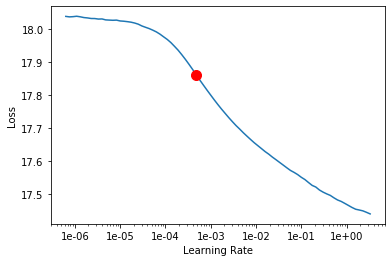

In [14]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [15]:
learner.fit_one_cycle(1, max_lr=5e-4)

epoch,train_loss,valid_loss,time
0,16.816484,17.013346,02:15


In [17]:
learner.save('Simple-CNN')

In [14]:
x, y = databunch.one_batch()
y_pred = model(x.cuda()).cpu().detach().numpy()

In [ ]:
one_example = list(y_pred) #[0][None,:,:]
decoded = pop.decode(one_example)
decoded